In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple

from torchdiffeq import odeint_adjoint as odeint

In [2]:
# set up the device, if the gpu is available, use the gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# setup the arguments in this notebook
args = {
    "niters": 1000, # epoches, the number of runs to run the training process
    "lr": 0.01, # the learning rate
    "rtol": 1e-5, # the rtol of the sde
    "atol": 1e-5, # the atol of the sde
}

In [4]:
'''
The latent ode func, return the gradient
'''
class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0
        
    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

In [5]:
class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim = 1, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim+nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim*2)
    
    def forward(self, x, h):
        combined = torch.cat((x,h), dim=1)
        # print(combined.size()) # [1000, 26]
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h
        
    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=1, nhidden=20):
        super(Decoder, self).__init__()
        self.relu=nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)
        
    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

In [7]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [8]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [9]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

In [10]:
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

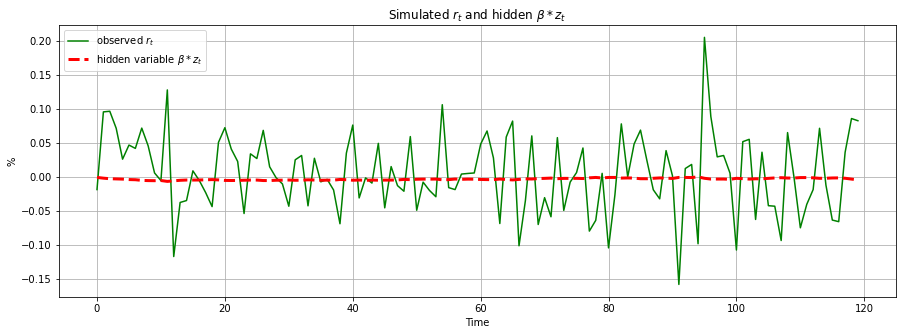

In [11]:
T = 120
beta = 0.1694
def make_time_series():
    
    
    phi = 0.9805
    sigma_v = 0.003342
    sigma_u = 0.0528
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0

    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t] + shocks[idx_t+1][0]
    return z, r
z, r = make_time_series()
plt.figure(figsize=(15,5))
xvalues = np.array(range(T))
plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
plt.plot(xvalues, beta*z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

plt.legend(loc="upper left")
plt.xlabel('Time')
plt.ylabel('%')
plt.grid(True)
plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
plt.show()

In [41]:
latent_dim = 1
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
batch_size=1000
T = 100

In [42]:
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [43]:
def generate_timeseries(nsample=100,
                      ):
    
    beta = 0.1694
    phi = 0.9805
    sigma_v = 0.003342
    sigma_u = 0.0528
    rho = -0.856
    cov_uv = rho * sigma_u * sigma_v

    # generating shocks
    mu = [0,0]
    cov = [[sigma_u**2, cov_uv], [cov_uv, sigma_v**2]]
    shocks = np.random.multivariate_normal(mu, cov, T)

    z0 = np.random.normal(0, sigma_u**2/(1-phi**2),1)
    r0 = shocks[0][0]

    z = np.zeros(T)
    r = np.zeros(T)
    z[0] = z0
    r[0] = r0
    
    
    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1][1]
        r[idx_t+1] = beta*z[idx_t] + shocks[idx_t+1][0]
    time_series = np.stack((r,np.array(range(T))),axis=1)
    plt.figure(figsize=(15,5))
    xvalues = np.array(range(T))
    plt.plot(xvalues, r, linestyle='-', color='g', label="observed $r_t$")
    plt.plot(xvalues, beta*z, linestyle="--", color="r", label=r"hidden variable $\beta * z_t$", linewidth=3.0)

    plt.legend(loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('%')
    plt.grid(True)
    plt.title(r"Simulated $r_t$ and hidden $\beta * z_t$")
    plt.show()

    samp = []
    for _ in range(batch_size):
        #t0_idx = npr.multinomial(
        #    1, [1. / (T - 2. * nsample)] * (T - int(2 * nsample)))
        #t0_idx = np.argmax(t0_idx) + nsample

        #samp_series = r[t0_idx:t0_idx + nsample].copy()
        #samp.append(samp_series)
        samp.append(time_series)
    
    samp = np.stack(samp, axis=0)
    #samp = samp[:,:,None]
    return r, z, samp, xvalues


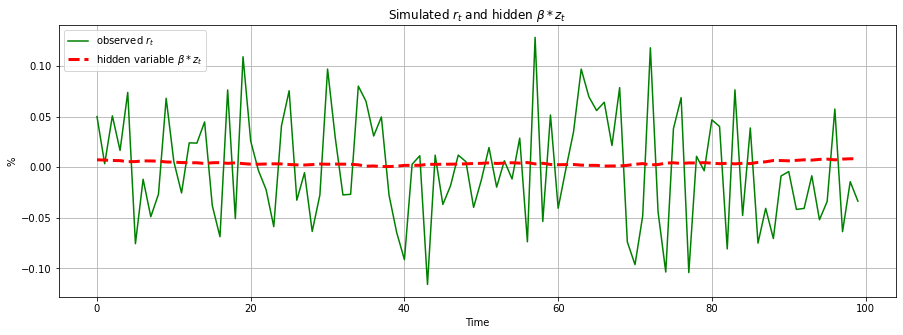

In [44]:
r,z,samp, ts = generate_timeseries()
samp, ts = torch.from_numpy(samp).float().to(device), torch.from_numpy(ts).float().to(device)

In [45]:
print(samp.size())

torch.Size([1000, 100, 2])


In [47]:
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=args["lr"])
kl_scheduler = LinearScheduler(iters=100)
loss_meter = RunningAverageMeter()
noise_std = .03
ts_ = ts.cpu().numpy()
for itr in range(1, args["niters"]+1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t in reversed(range(samp.size(1))):
        obs = samp[:,t,:]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:,:latent_dim], out[:,latent_dim:]
    eps = torch.randn(qz0_mean.size()).to(device)
    z0 = eps * torch.exp(.5*qz0_logvar)+qz0_mean
    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, ts[:samp.size(1)],atol=args["atol"], rtol=args["rtol"]).permute(1,0,2)

    pred_x = dec(pred_z)
    
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    #print(samp.size())
    #print(pred_x.size())
    logpx = log_normal_pdf(samp, pred_x,noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar, pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx, dim=0) + torch.mean(analytic_kl, dim=0)* kl_scheduler.val
    loss.backward()
    optimizer.step()
    kl_scheduler.step()
    loss_meter.update(loss.item())
    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
    
    if (itr+1) % 1 == 0:
        with torch.no_grad():
            h = rec.initHidden().to(device)
            for t in reversed(range(samp.size(1))):
                obs = samp[:,t,:]
                out, h = rec.forward(obs,h)
            qz0_mean, qz0_logvar = out[:,:latent_dim], out[:,latent_dim:]
            eps = torch.randn(qz0_mean.size()).to(device)
            z0 = eps * torch.exp(.5 * qz0_logvar)+qz0_mean
            
            # take first trajectory for visualization
            z0 = z0[0]
            pred_z = odeint(func, z0, ts, atol=args["atol"], rtol=args["rtol"])
            pred_x = dec(pred_z)
            pred_z, pred_x = pred_z.cpu().numpy(), pred_x.cpu().numpy()
            plt.figure()
            ts_ = ts.cpu().numpy()
            #plt.plot(ts_, z, label="true hidden")
            plt.plot(ts_, r, label="true dynamic")
            #plt.plot(ts_, pred_z, label="predicted hidden")
            plt.plot(ts_, pred_x[:,0], label="predicted dynamic")
            plt.legend()
            plt.savefig('./latent_ode/img/vis.png',dpi=500)
            plt.close()

Iter: 1, running avg elbo: -5863969390592.0000
Iter: 2, running avg elbo: -5805331526191.0400
Iter: 3, running avg elbo: -5747280041020.9697
Iter: 4, running avg elbo: -5689809069912.6797
Iter: 5, running avg elbo: -5632912807525.8730
Iter: 6, running avg elbo: -5576585506775.5742
Iter: 7, running avg elbo: -5520821478084.6182
Iter: 8, running avg elbo: -5465615088778.6514
Iter: 9, running avg elbo: -5410960762506.2256
Iter: 10, running avg elbo: -5356852978674.1230
Iter: 11, running avg elbo: -5303286271894.2617
Iter: 12, running avg elbo: -5250255231427.7998
Iter: 13, running avg elbo: -5197754500639.6016
Iter: 14, running avg elbo: -5145778776458.3252
Iter: 15, running avg elbo: -5094322808839.0225
Iter: 16, running avg elbo: -5043381400235.9121
Iter: 17, running avg elbo: -4992949405075.4727
Iter: 18, running avg elbo: -4943021729238.4775
Iter: 19, running avg elbo: -4893593329544.8125
Iter: 20, running avg elbo: -4844659213244.8838
Iter: 21, running avg elbo: -4796214437514.8350
I

KeyboardInterrupt: 